In [2]:
import pandas as pd
file = 'un-general-debates-blueprint.csv'
df = pd.read_csv(file)
df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


# Blueprint: Quick Overview with Pandas

In [3]:
df['length'] = df['text'].str.len()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [4]:
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


In [5]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [6]:
df['speaker'].fillna('unknown', inplace=True)

In [7]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

<AxesSubplot:>

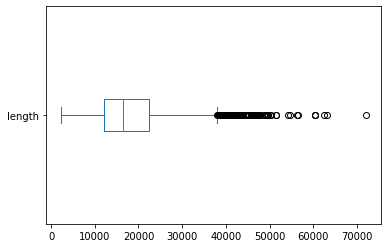

In [8]:
df['length'].plot(kind='box', vert=False)

<AxesSubplot:ylabel='Frequency'>

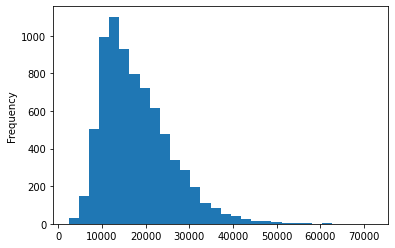

In [9]:
df['length'].plot(kind='hist', bins=30)

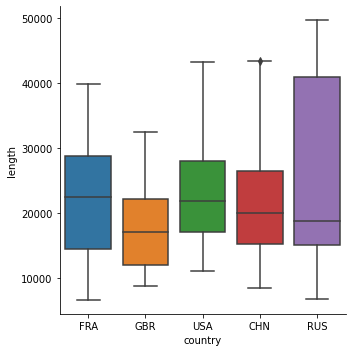

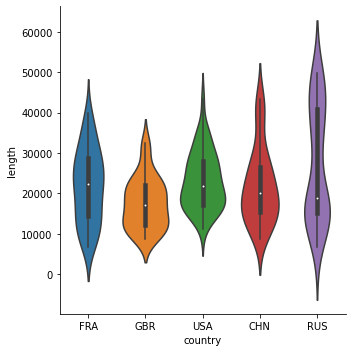

In [10]:
import seaborn as sns
where = df['country'].isin(['USA','FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data=df[where], x='country', y='length', kind='box')
sns.catplot(data=df[where], x='country', y='length', kind='violin')

<AxesSubplot:title={'center':'Number of countries'}, xlabel='year'>

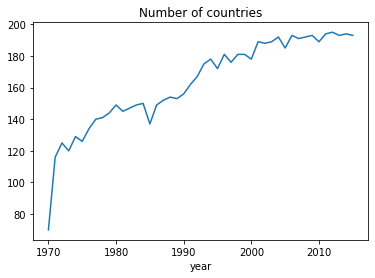

In [11]:
df.groupby('year').size().plot(title='Number of countries')

<AxesSubplot:title={'center':'Avg Speech Length'}, xlabel='year'>

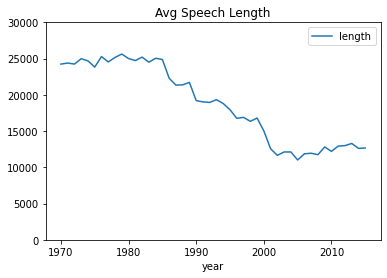

In [15]:
df.groupby('year').agg({'length': 'mean'}).plot(title='Avg Speech Length', ylim=(0,30000))

# Simple text preprocessing pipeline

In [21]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [18]:
import nltk
stopwords = set(nltk.corpus.stopwords.words('english'))

In [23]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [19]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

In [24]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [25]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df['num_tokens'] = df['tokens'].map(len)

# Counting Words with a Counter 

In [29]:
from collections import Counter

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into dataframe
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [30]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


# Creating a Frequency Diagram

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

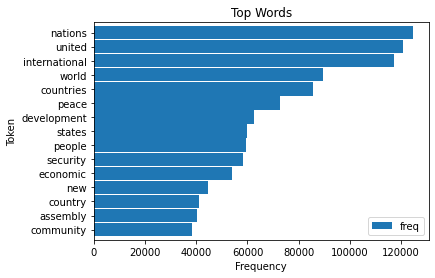

In [31]:
# dataframe from previous section is assumed
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Creating Word Clouds

## Blueprint

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, background_color='black', colormap='Paired', max_font_size=150, max_words=max_words)
    # convert dataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    
    # filter stopwords in freqency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

## Usage

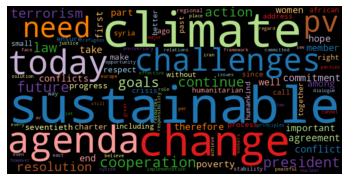

In [33]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)


# Ranking with TFIDF

## Blueprint

In [34]:
import numpy as np
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter  = Counter()
    df[column].map(update)

    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df']) + 0.1
    idf_df.index.name = 'token'
    return idf_df

## Usage

In [35]:
idf_df = compute_idf(df)

In [36]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

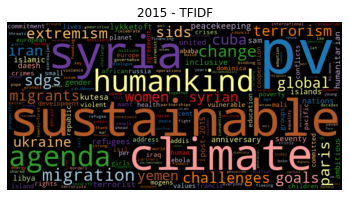

In [37]:
freq_1970 = count_words(df[df['year']==1970])
freq_2015 = count_words(df[df['year']==2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

wordcloud(freq_1970['freq'], title='1970 - TF', stopwords=['twenty-fifth', 'twenty-five'])
wordcloud(freq_2015['freq'], title='2015 - TF', stopwords=['seventieth'])
wordcloud(freq_1970['tfidf'], title='1970 - TFIDF', stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
wordcloud(freq_2015['tfidf'], title='2015 - TFIDF', stopwords=['seventieth'])


# Finding a Keyword in Context

In [40]:
from textacy.extract.kwic import keyword_in_context
import random
def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})


def kwic(doc_series, keyword, window=35, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, window_width=window, print_only=False))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} contexts for {keyword}:" )
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' + sample[1] + ' ' +re.sub(r'[\n\t]', ' ', sample[2]))

In [42]:
random.seed(22)
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

5 random samples out of 73 contexts for sdgs:
 of our planet and its people. The  SDGs  are a tangible manifestation of th
nd, we are expected to achieve the  SDGs  and to demonstrate dramatic develo
ead by example in implementing the  SDGs  in Bangladesh. Attaching due impor
the Sustainable Development Goals ( SDGs ). We applaud all the Chairs of the
new Sustainable Development Goals ( SDGs ) aspire to that same vision. The A


# Analyzing N-Grams

In [45]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) if len([t for t in ngram if t in stopwords]) == 0]


In [46]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]).apply(ngrams, n=2, stopwords=stopwords)
count_words(df, 'bigrams').head()

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


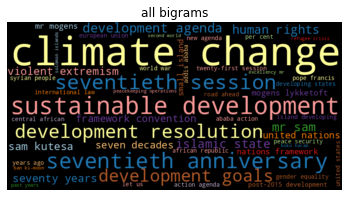

In [47]:
# concatenate existing IDF dataframe with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year']==2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

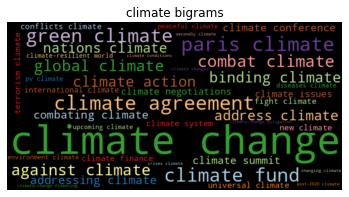

In [48]:
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='climate bigrams', max_words=50)

# Comparing Frequencies Across Time Intervals and Categories

In [49]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k,0) for k in keywords]


In [50]:
def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping columns
    return freq_df.groupby(by=by).sum().sort_values(by)
    

<AxesSubplot:xlabel='year'>

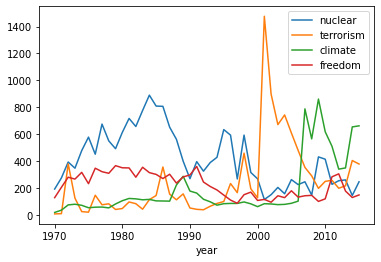

In [54]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df.plot()

<AxesSubplot:xlabel='year'>

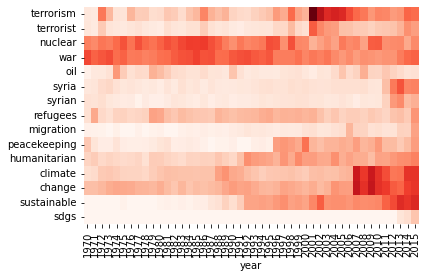

In [55]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', keywords=keywords)
# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)
sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap='Reds')